> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [TMDb movie data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This data set contains information
about 10,000 movies collected from
The Movie Database (TMDb),
including user ratings and revenue


### Question(s) for Analysis
>**Question 1**: What are the most 5 poplular movie genres and what is their revenue?

>**Question 2**: What are the most 2 associated genres?

>**Question 3**: What is the best studio that got these genres on the best rate?

>**Question 4**: How much money does it take to make a movie with these genres and with the best studio *Theoraticly* ? what is the possible revenue range ? 

In [187]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### Defining neccesary functions

In [188]:
def check_na_df(df:pd.DataFrame):
    '''
        parameters:
        df : the desired datafarme we wish to inspect
        this functions checks for nun values in each column of the desired df
        and returns a dataframe with the result 
    '''
    column_names = df.columns
    na_dict = {}
    for column in column_names:
        na_dict[column]=df[column].isna().sum()
    return pd.DataFrame(na_dict,index=['number of nan values']).transpose()

In [189]:
def seperating_strings_into_dfs(df:pd.DataFrame,column_name:str):
    '''
        parameters:
        df: pandas DataFrame
        column_name: String
        return: DataFrame
        In this function we are trying to split the strings with ('|') like('Action|Adventure|Thriller|Drama') 
        to a list ['Action','Adventure','Thriller','Drama'] and then map into this list to create a dictionary which we
        want to know how many times did this value repeated itself and added a value for the revenue and budget for each value
        to return in a dataframe to analyize it
    '''
    new_df=df.copy()
    new_df['budget'].fillna(new_df['budget'].mean(),inplace=True)
    new_df['revenue'].fillna(new_df['revenue'].mean(),inplace=True)
    new_df = new_df[[column_name,'budget','revenue']].dropna()
    seperated = {}
    for row in new_df.values:
        for value in row[0].split('|'):
            if(seperated.get(value)):
                seperated[value][0] +=1
                seperated[value][1] +=row[1]
                seperated[value][2] +=row[2]
            else:
                seperated[value]=[]
                seperated[value].append(1)
                seperated[value].append(row[1])
                seperated[value].append(row[2])
    return pd.DataFrame(seperated,index=['frequency','budget','revenue']).transpose().sort_values('frequency',ascending=False)

In [190]:
def getting_associated_genres(df:pd.DataFrame):
    '''
        parameters:
        df: DataFrame
        return DataFrame
        this functions goes into the genres column of the dataframe to find out top 2 common associated genres 
    '''
    associated_genres = {}
    for row in df:
        row_list = str(row).split('|')
        for first_value in range(len(row_list)):
            for second_value in range(first_value+1,len(row_list)):
                if(row_list[first_value]+'\n'+row_list[second_value] not in associated_genres):
                    if(row_list[second_value]+'\n'+row_list[first_value] not in associated_genres):
                        associated_genres[row_list[first_value]+'\n'+row_list[second_value]]=1
                    else:
                        associated_genres[row_list[second_value]+'\n'+row_list[first_value]]+=1
                else:
                    associated_genres[row_list[first_value]+'\n'+row_list[second_value]]+=1
    return pd.DataFrame(associated_genres,index=['Frequency']).transpose().sort_values('Frequency',ascending=False)

### information about missing values:
##### after checking for missing values I found out we lack some informations in the:(imdb_id,cast,director,tagline,keywords,and production companies,genres) columns which can't be replaced with custom values but not so important in our analysis and we also production companies is an important value but with only around 10% missing I believe we still can process now till we collect the missing values genres only missing 23 value it is far less than 0.01% but we are missing too many homepage,keywords,tagline but they can't be important for this analysis
### dataframe challenges:
##### It is noticed that alot of the string values: (genre,cast,producting companies) have list of data inside of it seperated with ( **|** ) so we gonna split them and create a dataframe for each
>### with the questions we want to ask it would be better if we used only the columns we are interested in

>### I chosed to  drop the na values as only companies will delete alot of info but we still using 90% of the data

id                       int64
budget                   int64
revenue                  int64
director                object
genres                  object
production_companies    object
dtype: object


,id,budget,revenue,director,genres,production_companies
0,135397,150000000,1513528810,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...
1,76341,150000000,378436354,George Miller,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...


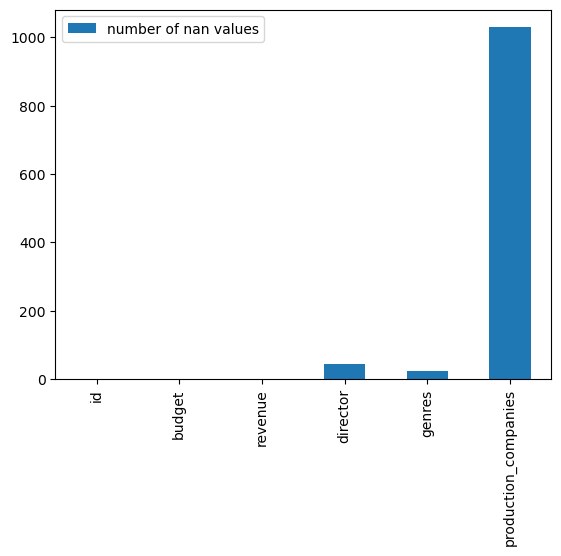

In [191]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('tmdb-movies.csv')
df= df[['id','budget','revenue','director','genres','production_companies']]
print(df.dtypes)
na_df=check_na_df(df=df)
na_df.plot(kind='bar');
df.head(2)


### Data Cleaning
> with only 10% of the data missing from the production company column which is important in our analysis, Decided to drop all the rows to stay with 90% of the data 

> Got all the DataFrames ready to analysis with spliting text and getting the associated genres

In [192]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df.dropna(inplace=True)
genres = seperating_strings_into_dfs(df=df,column_name='genres')
production_companies = seperating_strings_into_dfs(df=df,column_name='production_companies')
top_2_associated_genres=getting_associated_genres(df['genres'])

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Top 5 Common genres)
here I splited the genres to get every genre and its frequency, revenue, budget to analyize 
first I used the frequency to know the most common one

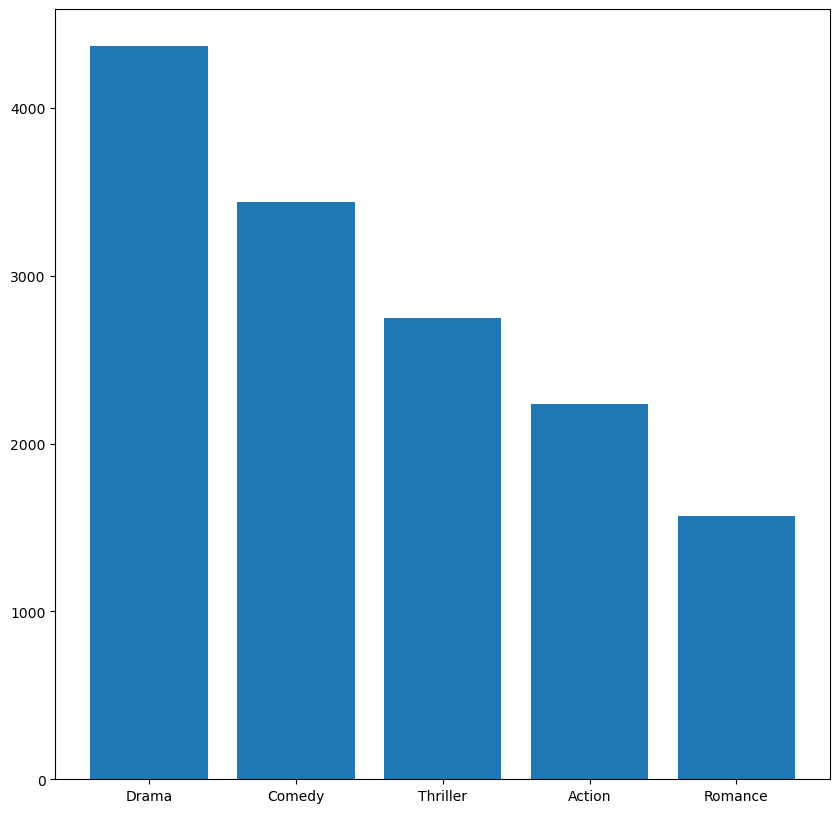

In [193]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
plt.figure(figsize=(10,10))
top_5_genres = genres.sort_values('frequency',ascending=False).head(5)
plt.bar(top_5_genres.index,top_5_genres['frequency']);

After that I got the revenue of each compared

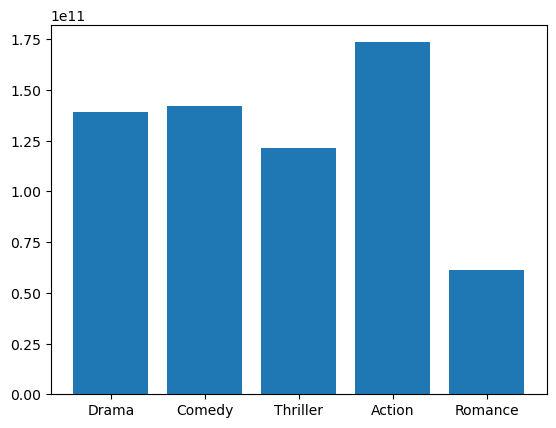

In [194]:
plt.bar(top_5_genres.index,top_5_genres['revenue']);

### Research Question 2  (Top 2 associated genres)
here I got all the 2 genres that came togather in movies and compared thier frequencies to get the top 2 genres

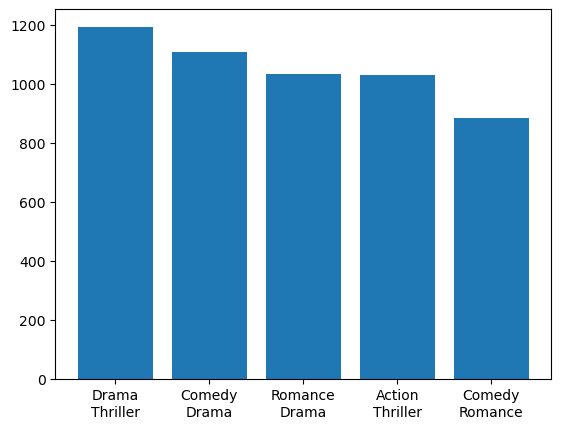

In [195]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
plt.bar(top_2_associated_genres.head().index,top_2_associated_genres.head()['Frequency']);

### Research Question 3  (which production company got these genres in the best rate)
here I got only the rows with drama and thriller genres togather and got the companies that casted them and compared the revenue between them

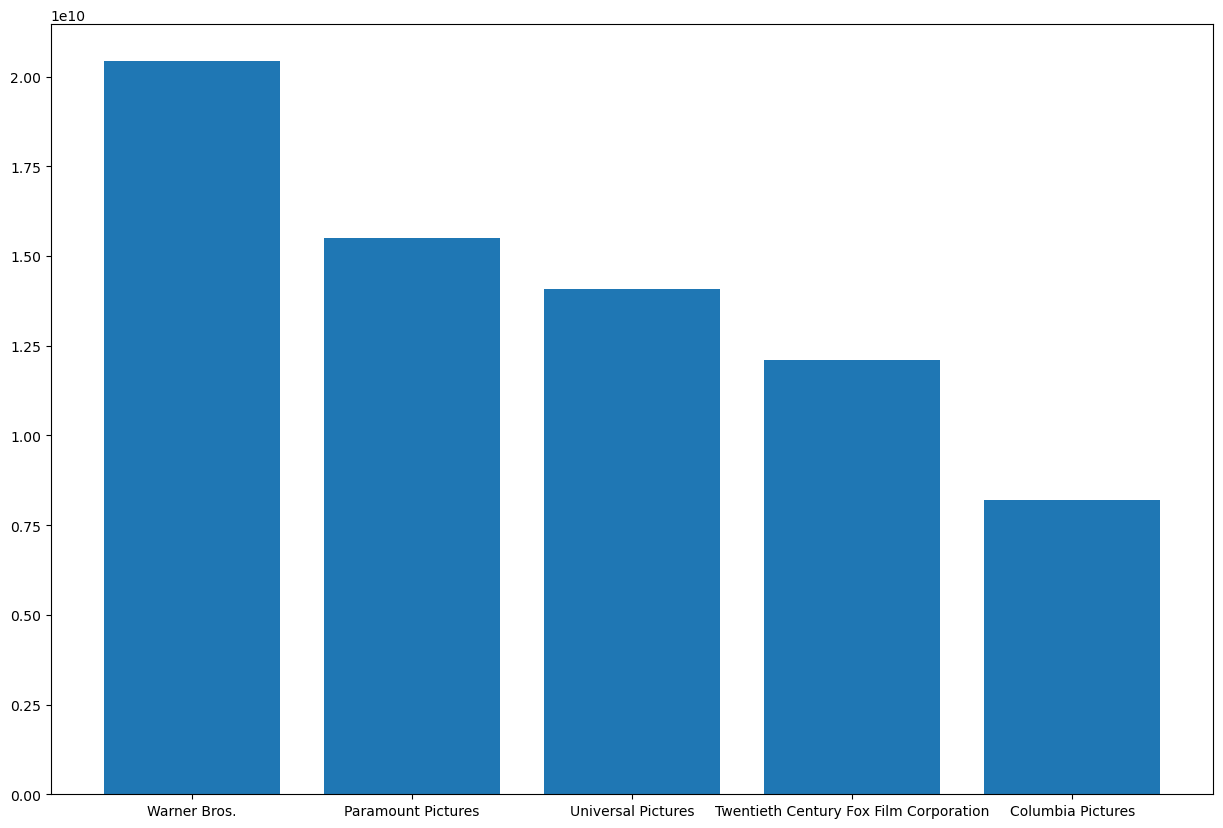

In [196]:

research_df = df.copy()
research_df=df[(df['genres'].str.contains('Drama'))]
research_df=df[df['genres'].str.contains('Thriller')]
research_df=research_df.sort_values('revenue',ascending=False)
companies_df=seperating_strings_into_dfs(research_df,'production_companies')
companies_df.sort_values('revenue',ascending=False,inplace=True)
plt.figure(figsize=(15,10));
plt.bar(companies_df.head().index,companies_df.head()['revenue']);

### Research Question 4  (How much money does it take to make a movie with these genres and with the best studio *Theoraticly* ? what is the possible revenue range ?)
###### first of all modified the dataframe to get only the rows where the company 'Warner Bros.' can be found
###### here I found that some of the revenues and budgets are 0s so I splitted them to proceed
###### divided them by 1million so the analysis can be easier

In [197]:
research_df = research_df[research_df['production_companies'].str.contains('Warner Bros.')]
research_df = research_df[research_df['budget']>0]
research_df = research_df[research_df['revenue']>0]
research_df

,id,budget,revenue,director,genres,production_companies
4363,49026,250000000,1081041287,Christopher Nolan,Action|Crime|Drama|Thriller,Legendary Pictures|Warner Bros.|DC Entertainme...
2875,155,185000000,1001921825,Christopher Nolan,Drama|Action|Crime|Thriller,DC Comics|Legendary Pictures|Warner Bros.|Syncopy
1919,27205,160000000,825500000,Christopher Nolan,Action|Thriller|Science Fiction|Mystery|Adventure,Legendary Pictures|Warner Bros.|Syncopy
4954,604,150000000,738599701,Lilly Wachowski|Lana Wachowski,Adventure|Action|Thriller|Science Fiction,Village Roadshow Pictures|NPV Entertainment|He...
5423,49047,105000000,716392705,Alfonso CuarÃ³n,Science Fiction|Thriller|Drama,Warner Bros.|Heyday Films|Esperanto Filmoj
...,...,...,...,...,...,...
8883,36047,15000000,5217498,Mary Lambert,Thriller,Warner Bros. Pictures
8788,18041,14000000,5108820,Davis Guggenheim,Drama|Mystery|Thriller,Warner Bros. Pictures
9932,636,777000,2437000,George Lucas,Drama|Mystery|Science Fiction|Thriller,American Zoetrope|Warner Bros.
9358,13154,8000000,2275557,Mark L. Lester,Action|Thriller,Warner Bros.


In [201]:
research_df['budget']=research_df['budget']/1000000
research_df['revenue']=research_df['revenue']/1000000

having all the credintals ready I started the analysis process

In [202]:
print(research_df[['budget','revenue']].describe())

           budget      revenue
count  136.000000   136.000000
mean    54.963434   146.642227
std     47.748327   193.031256
min      0.777000     0.428868
25%     19.750000    30.074329
50%     45.000000    78.561165
75%     70.000000   163.615694
max    250.000000  1081.041287


knowing that the IQR is 70 - 20 decided to go for all the values between 2 millions and 7 millions to know the average revenue which was between 3-13.5 million exactly 97.4 million

          budget     revenue
count  69.000000   69.000000
mean   44.523188   97.440133
std    14.358602   83.345413
min    20.000000   10.539000
25%    35.000000   30.303072
50%    45.000000   79.958599
75%    57.000000  135.458097
max    70.000000  411.006740


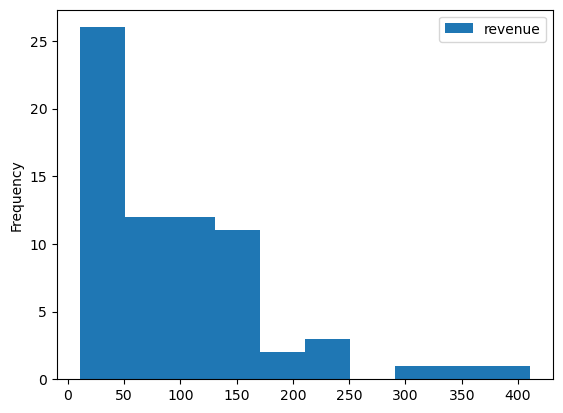

In [203]:

research_df=research_df[research_df['budget']>=20]
research_df=research_df[research_df['budget']<=70]
research_df[['revenue']].plot(kind='hist');
print(research_df[['budget','revenue']].describe())

<a id='conclusions'></a>
## Conclusions

> With the missing data about the production companies we could only provide 90% of the data tested having the last 10% would be great as well for the next analysis

> After analyzing we found out that the most common genres is (Drama , Comedy , Thriller , Action , Romance ) in order Even though action isn't the first in common but it is the first in revenue and drama is the third after comedy

> Then I wanted to know about the most 2 associated genres and It was Drama and Thriller with more than 1100 movie knowing that I could proceed to the next test

> Which companies can do the best out of these 2 genres and it was one of the biggest Warner Bros. knowing that we had all the credintals to the last test

> In average How much does it cost to produce 1 movie with all these credintals and what to expect with the revenue the answer was it can cost around (3->7 million) and it will return around (3->13.5 million) in average exactly as the mean is 97.4 million *but that's all theoraticly and can't be always true it can be effected with many other factors*

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [204]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1